In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

In [2]:
# useful functions

def show_images_in_table (images, table_size, fig_size = (10, 10), cmap=None, titles=None):
    """Shows images in table
    Args:
        images (list): list of input images
        table_size (tuple): (cols count, rows count)
        fig_size (tuple): picture (size x, size y) in inches
        cmap (list): list of cmap parameters for each image
        titles (list): list of images titles
    """
    sizex = table_size [0]
    sizey = table_size [1]
    fig, imtable = plt.subplots (sizey, sizex, figsize = fig_size, squeeze=False)
    for j in range (sizey):
        for i in range (sizex):
            im_idx = i + j*sizex
            if (isinstance(cmap, (list, tuple))):
                imtable [j][i].imshow (images[im_idx], cmap=cmap[i])
            else:
                im = images[im_idx]
                if len(im.shape) == 3:
                    imtable [j][i].imshow (im)
                else:
                    imtable [j][i].imshow (im, cmap='gray')
            imtable [j][i].axis('off')
            if not titles is None:
                imtable [j][i].set_title (titles [im_idx], fontsize=32)

    plt.show ()

def plt_show_gray (image):
    """Shows gray image
    Args:
        image: image to show
    """
    plt.figure ()
    plt.imshow (image, cmap='gray')
    plt.show ()

def plt_show (image):
    """Shows color image in RGB format
    Args:
        image: image to show
    """
    plt.figure ()
    plt.imshow (image)
    plt.show ()
    
# Visualizations will be shown in the notebook.
%matplotlib inline

dataset has cars: 8792
none cars: 8968


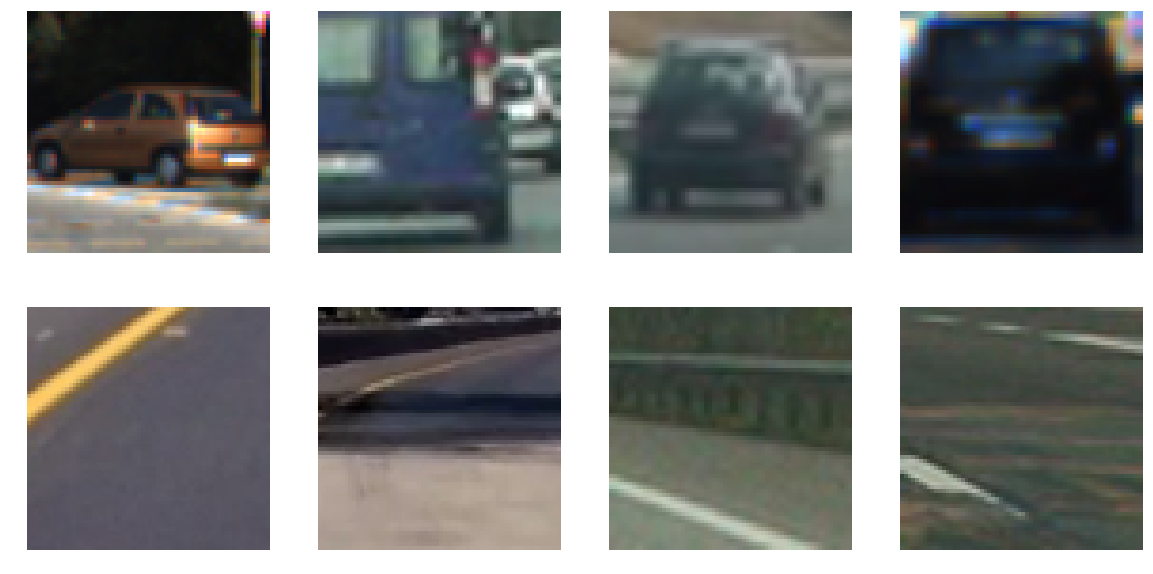

In [3]:
import random

cars = glob.glob('vehicles/vehicles/**/*.png', recursive=True)
notcars = glob.glob('non-vehicles/non-vehicles/**/*.png', recursive=True)

# cloading car images
car_image = []
for impath in cars:
    car_image.append (mpimg.imread(impath))

# loading non car images
notcar_image = []
for impath in notcars:
    notcar_image.append (mpimg.imread(impath))

car_image_count = len (car_image)
notcar_image_count = len (notcar_image)

print ('dataset has cars:', car_image_count)
print ('none cars:', notcar_image_count)

# show dataset images examples
example_images = [
    car_image [random.randint (0, car_image_count-1)],
    car_image [random.randint (0, car_image_count-1)],
    car_image [random.randint (0, car_image_count-1)],
    car_image [random.randint (0, car_image_count-1)],
    
    notcar_image [random.randint (0, notcar_image_count-1)],
    notcar_image [random.randint (0, notcar_image_count-1)],
    notcar_image [random.randint (0, notcar_image_count-1)],
    notcar_image [random.randint (0, notcar_image_count-1)]
]

show_images_in_table (example_images, (4, 2), fig_size=(20, 10))

In [4]:
# extracting additional samples from autti dataset
import csv
import random as rand

autti_samples_cars_count = 10000
autti_samples_notcars_count = 40000
autti_images_data = {}
cars_count = 0

# get autti dataset from https://github.com/udacity/self-driving-car/tree/master/annotations
# and extract into dataset/autti-object-dataset/ folder
# reading car boxes data from csv file (lines which contains "car" in 6th row)
# as a result we will have following structute
# autti_images_data = {
#    'image_filename' : {
#        'impath' : 'path/to/image',
#        'car_boxes' : [
#                {
#                    'x1' : int, # top left coords
#                    'y1' : int,
#                    'x2' : int, # bottom right coords
#                    'y2' : int
#                },
#                ...
#                all car boxes
#            ]
#    }
#    ...
#    all files
# }

with open('objectDataset/labels.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in reader:
        fname = row [0]
        if fname not in autti_images_data:
            image_data = {
                'impath' : 'objectDataset/' + fname,
                'car_boxes' : []
            }
            autti_images_data [fname] = image_data
        else:
            image_data = autti_images_data [fname]
            
        if (row[6] == '"car"'):
            car_data = {
                'x1' : int(row [1]),
                'y1' : int(row [2]),
                'x2' : int(row [3]),
                'y2' : int(row [4])
            }
            image_data ['car_boxes'].append (car_data)
            cars_count += 1

print ('autti images:', len (autti_images_data))
print ('  cars:', cars_count)

def is_intersect (box, boxes):
    """Check if box have intersection with other boxes
    Args:
        box (dict): box coords as
            {
                'x1' : int, # top left coords
                'y1' : int,
                'x2' : int, # bottom right coords
                'y2' : int
            }
        boxes (list): list of other boxes
    Returns:
        boolean: True if box has intersection with boxes, False otherwise
    """
    x1, x2, y1, y2 = box ['x1'], box ['x2'], box ['y1'], box ['y2']
    for b in boxes:
        bx1, bx2, by1, by2 = b ['x1'], b ['x2'], b ['y1'], b ['y2']
        if (
            (
                (
                    (x1 >= bx1 and x1 <= bx2) or 
                    (x2 >= bx1 and x2 <= bx2)
                ) and
                (
                    (y1 >= by1 and y1 <= by2) or 
                    (y2 >= by1 and y2 <= by2)
                )
            ) or
            (
                (
                    (bx1 >= x1 and bx1 <= x2) or 
                    (bx2 >= x1 and bx2 <= x2)
                ) and
                (
                    (by1 >= y1 and by1 <= y2) or 
                    (by2 >= y1 and by2 <= y2)
                )
            )
        ):
            return True
        
    return False

# also not car images will be extracted from autti dataset
# not car images will be square crops with following side size
not_car_box_size = [128, 64, 48]

def gen_not_car_box (size, car_boxes):
    """Randomly generate box inside of specified boundaries
    which have no intersections with specified boxes
    Args:
        size (list or tuple): size of area to generate box within
        car_boxes (list): boxes in the area which cannot be intersected
    Return:
        box(dict): resulting box in form of {'x1' : int, 'y1' : int, 'x2' : int, 'y2' : int}
    """
    while True:
        box_size = not_car_box_size [rand.randint (0, len (not_car_box_size)-1)]
        box_size = [box_size, box_size]
        available_poss = [
            size[0] - box_size[0],
            size[1] - box_size[1],
            ]
        pos = [
            rand.randint (0, available_poss[0] - 1),
            rand.randint (0, available_poss[1] - 1)
            ]
        box = {
            'x1': pos [0],
            'y1': pos [1],
            'x2': pos [0] + box_size [0],
            'y2': pos [1] + box_size [1]
        }
        if not is_intersect (box, car_boxes):
            return box
    

def augment_from_autti_dataset (cars_count, notcars_count):
    """Randomly pick images from autti dataset, crops car and not car images.
    resulting images will be resized to (64, 64)
    Args:
        cars_count (int): number of needed car images
        notcars_count (int): number of needed not car images
    Returns:
        cars (list), notcars(list) images which were cropped from autti dataset
        lists may hold slighly less number of images since
        cars_count and notcars_count specifies number of tries to crop.
        In some rare situations we have no images to crop
    """
    images_last_index = len (autti_images_data) - 1
    augmented_cars = []
    augmented_notcars = []
    keys = list(autti_images_data.keys ())
    for i in range (max (cars_count, notcars_count)):
        if i % 200 == 0:
            print ('augmented:', i)
        
        image_data = autti_images_data [keys[rand.randint (0, images_last_index)]]
        # if there is no car we will skip this image
        if len(image_data ['car_boxes']) == 0:
            continue
        
        carbox = image_data['car_boxes'][rand.randint(0, len(image_data ['car_boxes'])-1)]

        im = mpimg.imread(image_data ['impath'])
        im = im.astype(np.float32)/255

        #get car from image
        if i < cars_count:
            car_im = im[carbox['y1']:carbox['y2'], carbox['x1']:carbox['x2']]
            car_im = cv2.resize(car_im, (64, 64), interpolation=cv2.INTER_AREA)
            augmented_cars.append (car_im)
        
        #get not car from image
        if i < notcars_count:
            notcarbox = gen_not_car_box ([im.shape[1], im.shape[0]], image_data['car_boxes'])
            notcar_im = im[notcarbox['y1']:notcarbox['y2'], notcarbox['x1']:notcarbox['x2']]
            notcar_im = cv2.resize(notcar_im, (64, 64), interpolation=cv2.INTER_AREA)
            augmented_notcars.append (notcar_im)
        
    
    return augmented_cars, augmented_notcars

# this step takes about 40 mins
augmented_cars, augmented_notcars = augment_from_autti_dataset (autti_samples_cars_count, autti_samples_notcars_count)
print ('augmented cars:', len (augmented_cars))
print ('augmented not cars:', len (augmented_notcars))

autti images: 13063
  cars: 60788
augmented: 0
augmented: 200
augmented: 400
augmented: 600
augmented: 800
augmented: 1000
augmented: 1200
augmented: 1400
augmented: 1600
augmented: 1800
augmented: 2000
augmented: 2200
augmented: 2400
augmented: 2600
augmented: 2800
augmented: 3000
augmented: 3200
augmented: 3400
augmented: 3600
augmented: 3800
augmented: 4000
augmented: 4200
augmented: 4400
augmented: 4600
augmented: 4800
augmented: 5000
augmented: 5200
augmented: 5400
augmented: 5600
augmented: 5800
augmented: 6000
augmented: 6200
augmented: 6400
augmented: 6600
augmented: 6800
augmented: 7000
augmented: 7200
augmented: 7400
augmented: 7600
augmented: 7800
augmented: 8000
augmented: 8200
augmented: 8400
augmented: 8600
augmented: 8800
augmented: 9000
augmented: 9200
augmented: 9400
augmented: 9600
augmented: 9800
augmented: 10000
augmented: 10200
augmented: 10400
augmented: 10600
augmented: 10800
augmented: 11000
augmented: 11200
augmented: 11400
augmented: 11600
augmented: 11800
aug

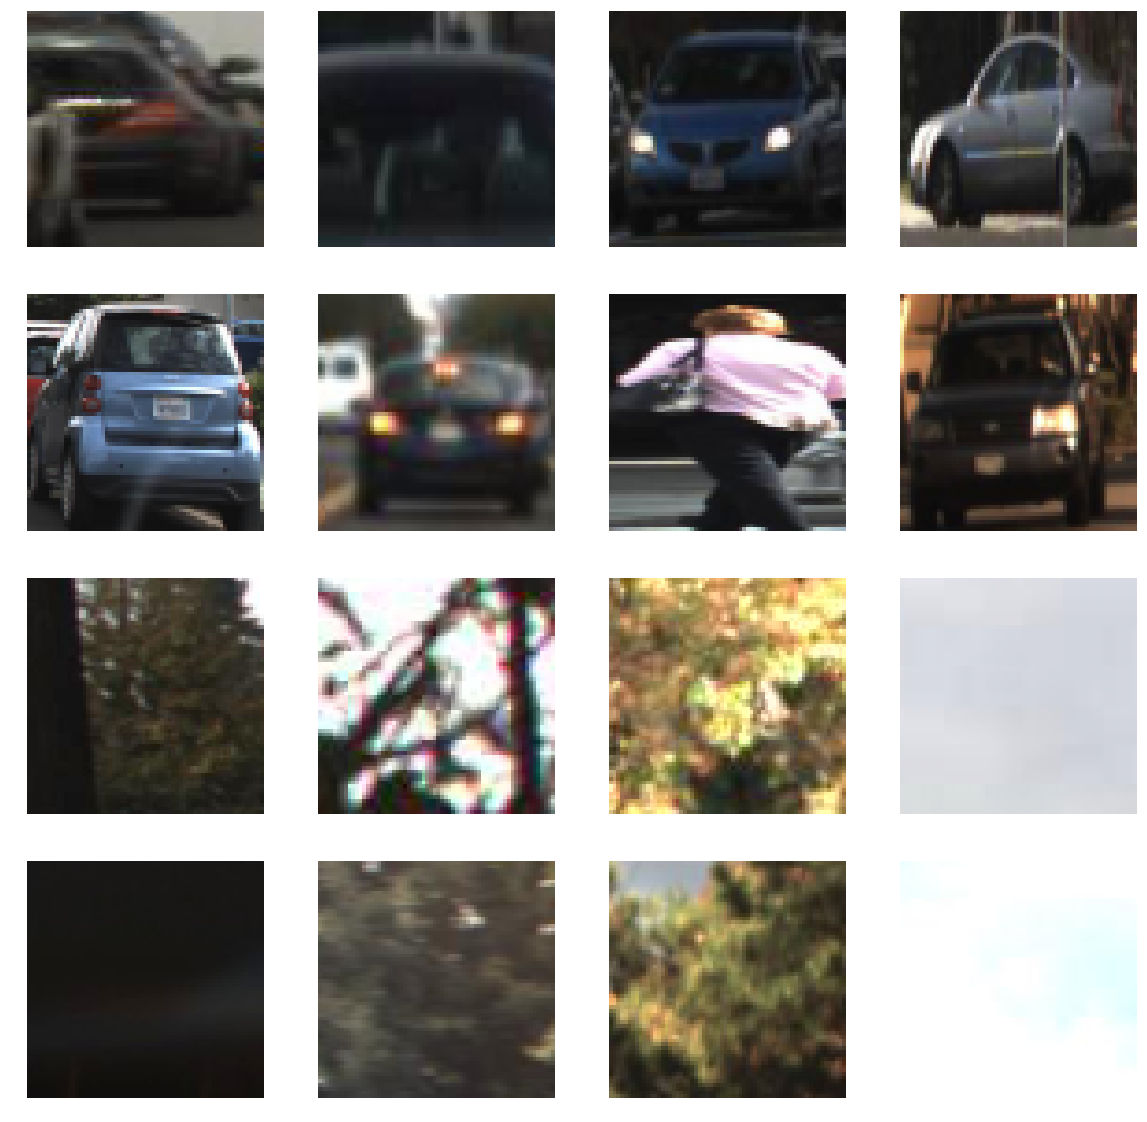

In [5]:
# show some samples generated from autti dataset

autti_example_images = [
    augmented_cars [random.randint (0, len (augmented_cars)-1)],
    augmented_cars [random.randint (0, len (augmented_cars)-1)],
    augmented_cars [random.randint (0, len (augmented_cars)-1)],
    augmented_cars [random.randint (0, len (augmented_cars)-1)],
    augmented_cars [random.randint (0, len (augmented_cars)-1)],
    augmented_cars [random.randint (0, len (augmented_cars)-1)],
    augmented_cars [random.randint (0, len (augmented_cars)-1)],
    augmented_cars [random.randint (0, len (augmented_cars)-1)],
    
    augmented_notcars [random.randint (0, len (augmented_notcars)-1)],
    augmented_notcars [random.randint (0, len (augmented_notcars)-1)],
    augmented_notcars [random.randint (0, len (augmented_notcars)-1)],
    augmented_notcars [random.randint (0, len (augmented_notcars)-1)],
    augmented_notcars [random.randint (0, len (augmented_notcars)-1)],
    augmented_notcars [random.randint (0, len (augmented_notcars)-1)],
    augmented_notcars [random.randint (0, len (augmented_notcars)-1)],
    augmented_notcars [random.randint (0, len (augmented_notcars)-1)]
]

show_images_in_table (autti_example_images, (4, 4), fig_size=(20, 20))


c:\users\pjcy0j\carnd_vehicle_detection\scikit-image\skimage\feature\_hog.py:116: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
c:\users\pjcy0j\carnd_vehicle_detection\scikit-image\skimage\feature\_hog.py:187: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


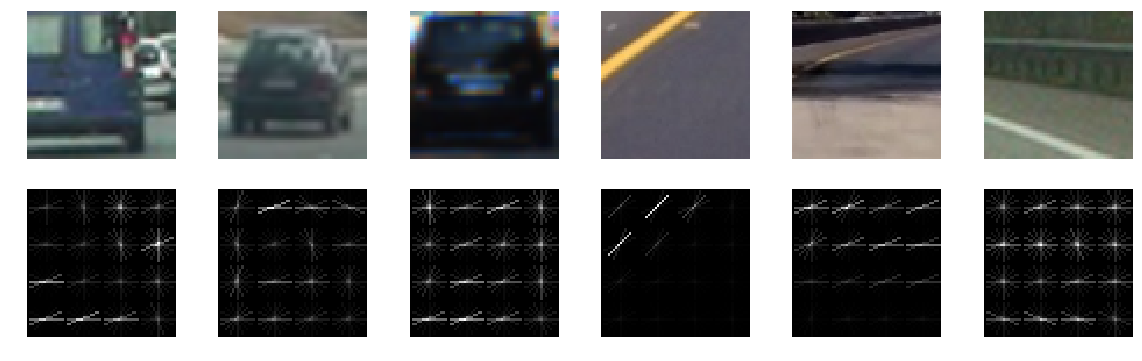

In [7]:
from skimage.feature import hog
import math

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """Return HOG features and its visualization if needed
    Args:
        img (numpy.array): image for feature extraction
        orient (int): number of orientations
        pix_per_cell (int): number of pixels in HOG cell
        cell_per_block (int): number of HOG cells in block
        vis (boolean): default False, return visualization image as second return parameter
        feature_vec (boolean): default True, return features as vector
    Returns:
        features or features, hog_image(image)
    """
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    """Calculated spatial features
    Args:
        img (numpy.array): image
        size (tuple): resize img before calculating features
            default value is (32, 32)
    Returns:
        feature_vector(numpy.array)
    """
    ch1 = cv2.resize(img[:,:,0], size).ravel() 
    ch2 = cv2.resize(img[:,:,1], size).ravel() 
    ch3 = cv2.resize(img[:,:,2], size).ravel() 
    features = np.concatenate ([ch1, ch2, ch3])
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 1)):
    """Calculate histograms of all channels of the image,
    concatenate and return it as feature vector
    Args:
        img (numpy.array): image
        nbins (int): number of histogram bins, 32 by default
        bins_range (tuple): range for bins values, default (0, 1)
    Returns:
        feature_vector(numpy.array)
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    """Extract spatial, color and hog features from single image
    Args:
        img (numpy.array): image in RGB format
        color_space: GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
        spatial_size (tuple): resize img before calculating spatial features
            default value is (32, 32)
        hist_bins (int): number of histogram bins, 32 by default
        orient (int): number of HOG orientations
        pix_per_cell (int): number of pixels in HOG cell
        cell_per_block (int): number of HOG cells in block
        hog_channel (int): channel to use for HOG features calculating, default 0
        spatial_feat (boolean): calculate spatial featues, default True
        hist_feat (boolean): calculate histogram featues, default True
        hog_feat (boolean): calculate HOG featues, default True
    Returns:
        features_vector (list(numpy.array)): list of feature vectors
    """
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        feature_image = cv2.cvtColor (img, getattr(cv2, 'COLOR_RGB2' + color_space))
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if color_space == 'GRAY':
            hog_features = get_hog_features(feature_image, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        elif hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """Extract spatial, color and hog features from specified list of images
    Args:
        imgs (list): list of images in RGB format
        color_space: GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
        spatial_size (tuple): resize img before calculating spatial features
            default value is (32, 32)
        hist_bins (int): number of histogram bins, 32 by default
        orient (int): number of HOG orientations
        pix_per_cell (int): number of pixels in HOG cell
        cell_per_block (int): number of HOG cells in block
        hog_channel (int): channel to use for HOG features calculating, default 0
        spatial_feat (boolean): calculate spatial featues, default True
        hist_feat (boolean): calculate histogram featues, default True
        hog_feat (boolean): calculate HOG featues, default True
    Returns:
        features_vector (numpy.array)
    """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = cv2.cvtColor (image, getattr(cv2, 'COLOR_RGB2' + color_space))
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if color_space == 'GRAY':
                hog_features = get_hog_features(feature_image, orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            elif hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    """Apply specified classificator to specified windows
    and returns hot windows - windows classified as holding interesting object
    Args:
        img (numpy.array): image to search
        windows (list): list of coordinates of sliding windows in form of
            ((top left x, top left y), (bottom right x, bottom right y))
        spatial_size (tuple): resize img before calculating spatial features
            default value is (32, 32)
        hist_bins (int): number of histogram bins, 32 by default
        orient (int): number of HOG orientations
        pix_per_cell (int): number of pixels in HOG cell
        cell_per_block (int): number of HOG cells in block
        hog_channel (int): channel to use for HOG features calculating, default 0
        spatial_feat (boolean): calculate spatial featues, default True
        hist_feat (boolean): calculate histogram featues, default True
        hog_feat (boolean): calculate HOG featues, default True
    Returns:
        list of hot windows
    """
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64), interpolation=cv2.INTER_AREA)      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """Create and return sliding window lattice as list of sliding windows
    Args:
        img (numpy.array): image to search
        x_start_stop (list): horizontal limits, if [None, None] then [0, image width]  will be used
        y_start_stop (list): vertical   limits, if [None, None] then [0, image height] will be used
        xy_window (tuple): sliding window size, default is (64, 64)
        xy_overlap (tuple): sliding window overlap factor, default is (0.5, 0.5)
    Returns:
        list of windows
    """
    # If x and/or y start/stop positions not defined, set to image size
    imgsizey = img.shape [0]
    imgsizex = img.shape [1]
    x_start_stop [0] = 0 if x_start_stop [0] is None else x_start_stop [0]
    x_start_stop [1] = imgsizex if x_start_stop [1] is None else x_start_stop [1]
    y_start_stop [0] = 0 if y_start_stop [0] is None else y_start_stop [0]
    y_start_stop [1] = imgsizey if y_start_stop [1] is None else y_start_stop [1]
    # Compute the span of the region to be searched
    sizex = x_start_stop [1] - x_start_stop [0]
    sizey = y_start_stop [1] - y_start_stop [0]
    # Compute the number of pixels per step in x/y
    stepx = int (xy_window [0] * xy_overlap [0])
    stepy = int (xy_window [1] * xy_overlap [1])
    # Compute the number of windows in x/y
    step_count_x = int (math.floor(1.0 * sizex / stepx)) - 1
    step_count_y = int (math.floor(1.0 * sizey / stepy)) - 1
    # Initialize a list to append window positions to
    window_list = []
    for i in range (step_count_y):
        for j in range (step_count_x):
            # Calculate each window position
            # Append window position to list
            window_list.append ((
                (x_start_stop [0] + j*stepx, y_start_stop [0] + i*stepy),
                (x_start_stop [0] + j*stepx + xy_window [0], y_start_stop [0] + i*stepy + xy_window [1])
                ))
    # Return the list of windows
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """Draws windows or bounding boxes on the image
    Args:
        img (numpy.array): image to search
        bboxes (list): bounding boxes
        color (tuple): bounding box color, default is (0, 0, 255)
        thick (int): thickness of bounding box, default is 6 pixels
    Returns:
        image copy with boxes drawn
    """
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def get_s_from_hls (img):
    hls = cv2.cvtColor (img, cv2.COLOR_BGR2HLS)
    return hls [:,:,2]

# parameters of feature extraction

color_space = 'GRAY' # Can be GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 1 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

images_for_features = list (example_images [1:-1])

feature_examples = []
feature_examples.extend (images_for_features)

for im in images_for_features:
    features, hog_image = get_hog_features(get_s_from_hls(im), orient, pix_per_cell, cell_per_block, vis=True)
    feature_examples.append (hog_image)
    
show_images_in_table (feature_examples, (6, 2), fig_size=(20, 6))


In [ ]:
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# combine original and autti datasets and extract features

# original dataset seems to have black cars bias
# so I use only 4000 car images and about 10K car images from autti
all_cars = []
all_cars.extend (car_image [:4000])
all_cars.extend (augmented_cars)

# I use bigger number of not car images
all_notcars = []
all_notcars.extend (notcar_image)
all_notcars.extend (augmented_notcars)

print ('result dataset:', len(all_cars), 'cars /', len(all_notcars), 'not cars')

ft=time.time()
car_features = extract_features(all_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(all_notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
ft2=time.time()
print ('features extraction time: ', round(ft2-ft, 2))

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

result dataset: 13791 cars / 48138 not cars
features extraction time:  73.91
Using: 8 orientations 16 pixels per cell and 1 cells per block
Feature vector length: 128


In [ ]:
# I use default rbf kernel SVM
svc = SVC ()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Test Accuracy of SVC =  0.9773


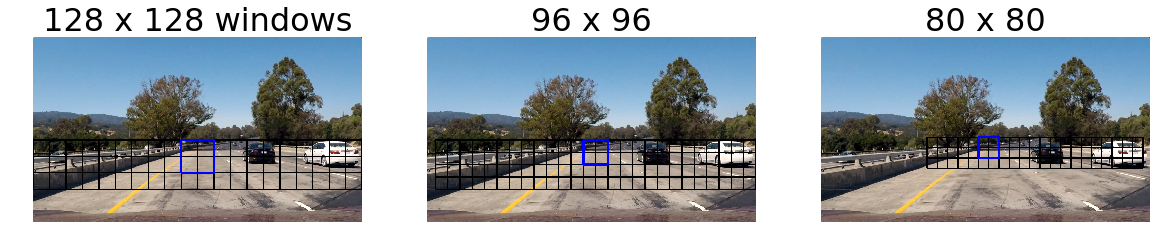

In [ ]:
# defining parameters of sliding windows
# I use 3 sliding windows with different sizes, and different positions

image = mpimg.imread('test_images/test1.jpg')
window_img = np.copy(image)

sw_x_limits = [
    [None, None],
    [32, None],
    [412, 1280]
]

sw_y_limits = [
    [400, 640],
    [400, 600],
    [390, 540]
]

sw_window_size = [
    (128, 128),
    (96, 96),
    (80, 80)
]

sw_overlap = [
    (0.5, 0.5),
    (0.5, 0.5),
    (0.5, 0.5)
]

# create sliding windows
windows = slide_window(image, x_start_stop=sw_x_limits[0], y_start_stop=sw_y_limits[0], 
                    xy_window=sw_window_size[0], xy_overlap=sw_overlap[0])

windows2 = slide_window(image, x_start_stop=sw_x_limits[1], y_start_stop=sw_y_limits[1], 
                    xy_window=sw_window_size[1], xy_overlap=sw_overlap[1])

windows3 = slide_window(image, x_start_stop=sw_x_limits[2], y_start_stop=sw_y_limits[2], 
                    xy_window=sw_window_size[2], xy_overlap=sw_overlap[2])

# show sliding windows
sliding_windows = []
sliding_windows.append (draw_boxes(np.copy(image), windows, color=(0, 0, 0), thick=4))
sliding_windows.append (draw_boxes(np.copy(image), windows2, color=(0, 0, 0), thick=4))
sliding_windows.append (draw_boxes(np.copy(image), windows3, color=(0, 0, 0), thick=4))

# drawing one of sliding windows in blue
sliding_windows [0] = draw_boxes (sliding_windows [0], [windows[9]], color=(0, 0, 255), thick=8)
sliding_windows [1] = draw_boxes (sliding_windows [1], [windows2[12]], color=(0, 0, 255), thick=8)
sliding_windows [2] = draw_boxes (sliding_windows [2], [windows3[5]], color=(0, 0, 255), thick=8)

sw_titles = [
    '128 x 128 windows',
    '96 x 96',
    '80 x 80'
]

show_images_in_table (sliding_windows, (3, 1), fig_size=(20, 14), titles=sw_titles)

In [ ]:
def get_hot_boxes (image):
    """Applies sliding windows to images
    and finds hot windows. Also returns image with all hot boxes are drawn
    Args:
        image (numpy.array): image
    Returns:
        hot_windows(list), image_with_hot_windows_drawn(numpy.array)
    """

    dst = np.copy (image)
    all_hot_windows = []
    
    # iterate over previousely defined sliding windows
    for x_limits, y_limits, window_size, overlap in zip (sw_x_limits, sw_y_limits, sw_window_size, sw_overlap):

        windows = slide_window(
            dst,
            x_start_stop=x_limits,
            y_start_stop=y_limits, 
            xy_window=window_size,
            xy_overlap=overlap
        )

        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
        
        all_hot_windows.extend (hot_windows)

        dst = draw_boxes(dst, hot_windows, color=(0, 0, 1), thick=4)

    return all_hot_windows, dst
        
def get_heat_map(image, bbox_list):
    """Computes heat map of hot windows. Puts all specified
    hot windows on top of each other, so every pixel of returned image will
    contain how many hot windows covers this pixel
    Args:
        image (numpy.array): image
    Returns:
        heatmap (numpy.array) grayscale image of the same size as input image
    """

    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)

    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap

class AverageHotBox ():
    """Class that covers joining hot boxes algorithm.
    We have many less or more overlapped boxes and we need to
    join it around peaks to convert many overlapped boxes into
    smaller amount of not or slightly overlapped ones.
    Idea is take fist box (called average box) form input boxes
    and join it with all boxes
    that is close enough (here for two boxes:
    they need to overlap by 30% of area of any one of two)
    After joining two boxes we need to update average box (here
    just increasing size to cover both joining boxes).
    Loop while we are able to join futhermore.
    For left boxes repeat all procedure.
    As a result we may also get average boxes strengths, the number of
    boxes it was joined to.
    This class represents one average box.
    """
    def __init__ (self, box):
        self.avg_box = [list(p) for p in box]
        self.detected_count = 1
        self.boxes = [box]
    
    def get_strength (self):
        """Returns number of joined boxes"""
        return self.detected_count
    
    def get_box (self):
        """Uses joined boxes information to compute
        this average box representation as hot box.
        This box has average center of all boxes and have
        size of 2 standard deviation by x and y coordinates of its points
        """
        if len(self.boxes) > 1:
            center = np.average (np.average (self.boxes, axis=1), axis=0).astype(np.int32).tolist()

            # getting all x and y coordinates of
            # all corners of joined boxes separately
            xs = np.array(self.boxes) [:,:,0]
            ys = np.array(self.boxes) [:,:,1]

            half_width = int(np.std (xs))
            half_height = int(np.std (ys))
            return (
                (
                    center[0] - half_width,
                    center[1] - half_height
                ), (
                    center[0] + half_width,
                    center[1] + half_height
                ))
        else:
            return self.boxes [0]
    
    def is_close (self, box):
        """Check wether specified box is close enough for joining
        to be close need to overlap by 30% of area of this box or the average box
        """
        
        # Thank you, davin
        # http://math.stackexchange.com/questions/99565/simplest-way-to-calculate-the-intersect-area-of-two-rectangles
        x11 = self.avg_box [0][0]
        y11 = self.avg_box [0][1]
        x12 = self.avg_box [1][0]
        y12 = self.avg_box [1][1]
        x21 = box [0][0]
        y21 = box [0][1]
        x22 = box [1][0]
        y22 = box [1][1]
            
        x_overlap = max(0, min(x12,x22) - max(x11,x21))
        y_overlap = max(0, min(y12,y22) - max(y11,y21))

        area1 = (x12 - x11) * (y12 - y11)
        area2 = (x22 - x21) * (y22 - y21)
        intersection = x_overlap * y_overlap;
        
        if (
            intersection >= 0.3 * area1 or
            intersection >= 0.3 * area2
        ):
            return True
        else:
            return False
    
    def join (self, boxes):
        """Join in all boxes from list of given boxes,
        removes joined boxes from input list of boxes
        """
        
        joined = False
        
        for b in boxes:
            if self.is_close (b):
                boxes.remove (b)
                self.boxes.append (b)
                self.detected_count += 1
                
                self.avg_box [0][0] = min (self.avg_box [0][0], b [0][0])
                self.avg_box [0][1] = min (self.avg_box [0][1], b [0][1])
                self.avg_box [1][0] = max (self.avg_box [1][0], b [1][0])
                self.avg_box [1][1] = max (self.avg_box [1][1], b [1][1])
                
                joined = True

        return joined

def calc_average_boxes (hot_boxes, strength):
    """Compute average boxes from specified hot boxes and returns
    average boxes with equals or higher strength
    """
    avg_boxes = []
    while len(hot_boxes) > 0:
        b = hot_boxes.pop (0)
        hb = AverageHotBox (b)
        while hb.join (hot_boxes):
            pass
        avg_boxes.append (hb)
    
    boxes = []
    for ab in avg_boxes:
        if ab.get_strength () >= strength:
            boxes.append (ab.get_box ())
    return boxes

c:\users\pjcy0j\carnd_vehicle_detection\scikit-image\skimage\feature\_hog.py:116: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
c:\users\pjcy0j\carnd_vehicle_detection\scikit-image\skimage\feature\_hog.py:187: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


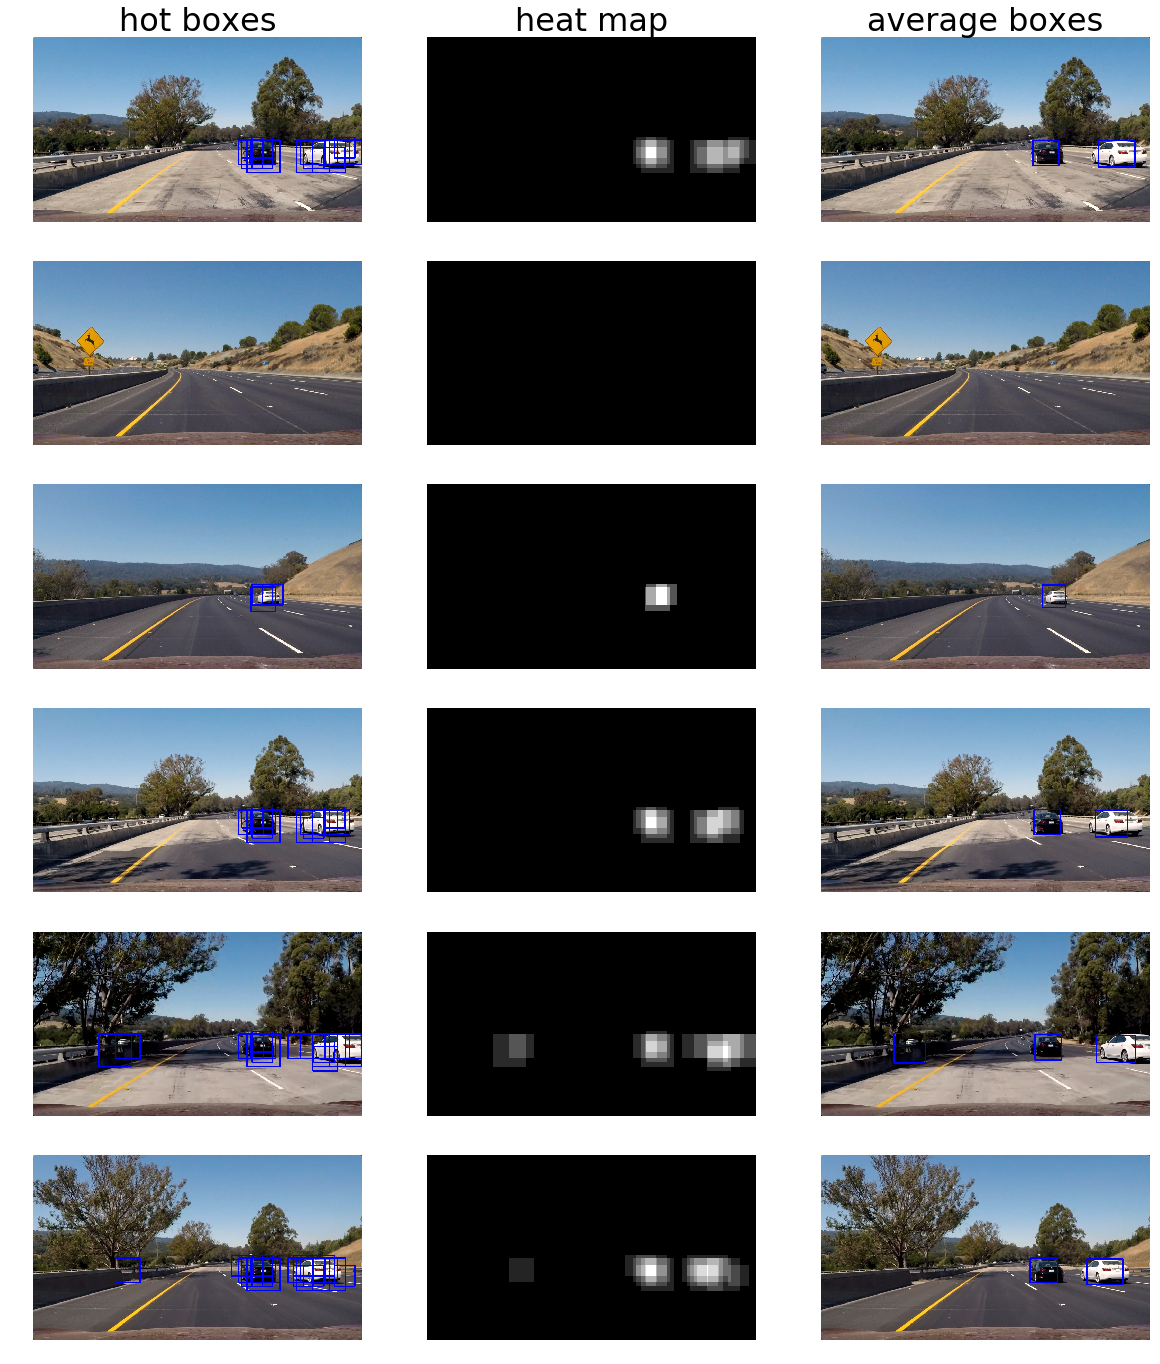

In [ ]:
# algorithm demonstration on test images

test_images = []
test_images_titles = []

for impath in glob.glob('test_images/test*.jpg'):
    image_orig = mpimg.imread(impath)
    
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image_orig.astype(np.float32)/255

    # hot boxes
    hot_boxes, image_with_hot_boxes = get_hot_boxes (image)
    # heat map
    heat_map = get_heat_map (image, hot_boxes)
    
    # average boxes
    avg_boxes = calc_average_boxes (hot_boxes, 2)
    image_with_boxes = draw_boxes(image, avg_boxes, color=(0, 0, 1), thick=4)
    
    test_images.append (image_with_hot_boxes)
    test_images.append (heat_map)
    test_images.append (image_with_boxes)
    
    test_images_titles.extend (['', '', ''])
    
test_images_titles [0] = 'hot boxes'
test_images_titles [1] = 'heat map'
test_images_titles [2] = 'average boxes'

show_images_in_table (test_images, (3, 6), fig_size=(20, 24), titles=test_images_titles)


In [ ]:
# in video I use information from multiple frames to
# make average boxes more robust and filter false positives
# I accumulate all hot boxes from last several frames and use them
# for calculating average boxes

class LastHotBoxesQueue ():
    """Class for accumulation of hot boxes from last 10 frames
    """
    def __init__ (self):
        self.queue_max_len = 10 # number items to store
        self.last_boxes = []

    def put_hot_boxes (self, boxes):
        """Put frame hot boxes
        """
        if (len(self.last_boxes) > self.queue_max_len):
            tmp = self.last_boxes.pop (0)
        
        self.last_boxes.append (boxes)
        
    def get_hot_boxes (self):
        """Get last 10 frames hot boxes
        """
        b = []
        for boxes in self.last_boxes:
            b.extend (boxes)
        return b

last_hot_boxes = LastHotBoxesQueue ()
    
def process_image (image_orig):
    
    image_orig = np.copy (image_orig)
    image = image_orig.astype(np.float32)/255
    
    # accumulating hot boxes over 10 last frames
    hot_boxes, image_with_hot_boxes = get_hot_boxes (image)
    last_hot_boxes.put_hot_boxes (hot_boxes)
    hot_boxes = last_hot_boxes.get_hot_boxes ()
    
    # calculating average boxes and use strong ones
    # need to tune strength on particular classifer
    avg_boxes = calc_average_boxes (hot_boxes, 20)
    image_with_boxes = draw_boxes(image, avg_boxes, color=(0, 0, 1), thick=4)

    return image_with_boxes * 255

In [ ]:
from moviepy.editor import VideoFileClip
# import imageio
# imageio.plugins.ffmpeg.download()

def process_video (input_path, output_path):
    clip = VideoFileClip (input_path)
    
    # uncomment to operate on individual frames
#     image = clip.get_frame(8./30)
#     r = process_image(image)
#     plt_show (r/255)

    result = clip.fl_image (process_image)
    %time result.write_videofile (output_path)

# select video to operate on
process_video ('project_video.mp4', 'project_video_result.mp4')


[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing audio in project_video_resultTEMP_MPY_wvf_snd.mp3


100%|█████████████████████████████████████| 1112/1112 [00:03<00:00, 363.68it/s]


[MoviePy] Done.
[MoviePy] Writing video project_video_result.mp4


100%|█████████████████████████████████████▉| 1260/1261 [07:42<00:00,  2.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

Wall time: 7min 56s
